In [1]:
import os, argparse, sys 
sys.path.append('..')
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils as vutils
from ALI_BiGAN.model import Generator, Encoder, Discriminator
from ALI_BiGAN.util import weights_init, log_sum_exp, get_log_odds

batch_size = 100
latent_size = 256
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', help='cifar10 | svhn', default="cifar10")
parser.add_argument('--dataroot', help='path to dataset', default="../data/ALI_BiGAN/cifar10")
parser.add_argument('--save_model_dir', default="../models/ALI_BiGAN")
parser.add_argument('--save_image_dir', default="../data/ALI_BiGAN")
opt = parser.parse_args([])

In [2]:
!ls ../models/ALI_BiGAN

D_epoch_0.pth	D_epoch_60.pth	E_epoch_20.pth	E_epoch_80.pth	G_epoch_40.pth
D_epoch_10.pth	D_epoch_70.pth	E_epoch_30.pth	E_epoch_90.pth	G_epoch_50.pth
D_epoch_20.pth	D_epoch_80.pth	E_epoch_40.pth	G_epoch_0.pth	G_epoch_60.pth
D_epoch_30.pth	D_epoch_90.pth	E_epoch_50.pth	G_epoch_10.pth	G_epoch_70.pth
D_epoch_40.pth	E_epoch_0.pth	E_epoch_60.pth	G_epoch_20.pth	G_epoch_80.pth
D_epoch_50.pth	E_epoch_10.pth	E_epoch_70.pth	G_epoch_30.pth	G_epoch_90.pth


In [3]:
if opt.dataset == 'svhn':
    train_loader = torch.utils.data.DataLoader(
        datasets.SVHN(root=opt.dataroot, split='extra', download=True,
                      transform=transforms.Compose([transforms.ToTensor()])),
        batch_size=batch_size, shuffle=True)
elif opt.dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=opt.dataroot, train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()])),
        batch_size=batch_size, shuffle=True)
else:
    raise NotImplementedError

epoch = 90
E = Encoder(latent_size, True)
G = Generator(latent_size)
D = Discriminator(latent_size, 0.2, 1)
E.load_state_dict(torch.load(str(Path(opt.save_model_dir) / f'E_epoch_{epoch}.pth')))
G.load_state_dict(torch.load(str(Path(opt.save_model_dir) / f'G_epoch_{epoch}.pth')))
D.load_state_dict(torch.load(str(Path(opt.save_model_dir) / f'D_epoch_{epoch}.pth')))

Files already downloaded and verified


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [9]:
z_fake = torch.randn(batch_size, latent_size, 1, 1)
d_fake = G(z_fake)
images = d_fake.detach().permute(0, 2, 3, 1).numpy()

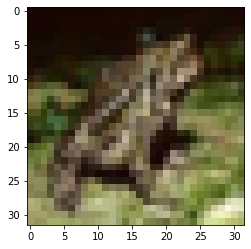

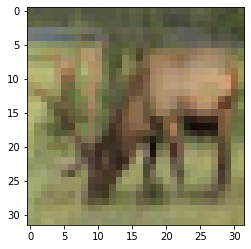

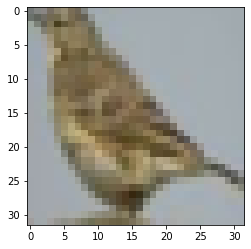

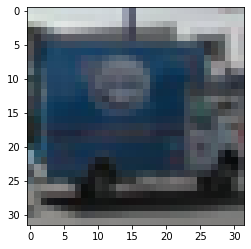

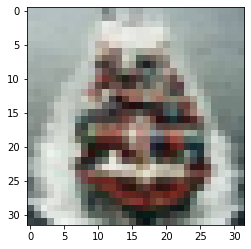

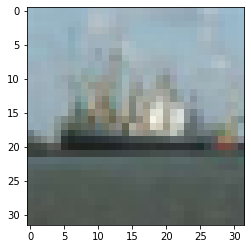

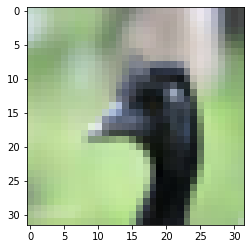

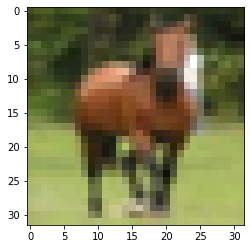

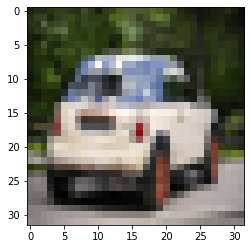

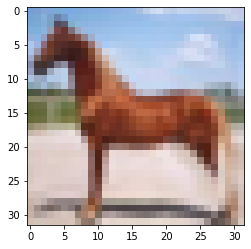

In [35]:
for i in range(10):
    plt.imshow(images[i])
    plt.show()

In [11]:
d_real, classes = next(iter(train_loader))  
images = d_real.detach().permute(0, 2, 3, 1).numpy()

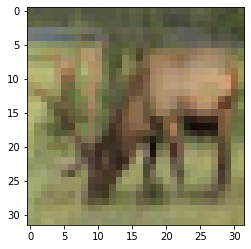

In [15]:
plt.imshow(images[1])

In [16]:
z_real, _, _, _ = E(d_real)

In [21]:
print(z_fake.shape)
print(z_real.shape)
print(d_fake.shape)
print(d_real.shape)

torch.Size([100, 256, 1, 1])
torch.Size([100, 512, 1, 1])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])


In [27]:
squeezed_z_fake = z_fake.squeeze(dim=-1).squeeze(dim=-1)
squeezed_z_real = z_real.squeeze(dim=-1).squeeze(dim=-1)

In [28]:
squeezed_z_real

tensor([[-2.1236, -0.8807,  0.3891,  ...,  0.7663, -3.5374, -1.2091],
        [-1.6058,  0.3048,  0.2576,  ...,  1.2943, -3.6586, -1.1563],
        [-0.7702, -0.0350,  0.4821,  ...,  0.2088, -4.3754, -2.0163],
        ...,
        [-1.3955,  0.0307,  1.1211,  ...,  1.8921, -5.9230, -2.0412],
        [-1.2882, -0.5877,  0.8084,  ...,  0.2488, -4.0310, -1.2109],
        [-0.2613,  0.3355,  1.3154,  ..., -0.0712, -4.5405, -2.4276]],
       grad_fn=<SqueezeBackward1>)

In [33]:
F.kl_div(squeezed_z_fake[0],squeezed_z_real[1][:256])

tensor(-0.0648, grad_fn=<KlDivBackward>)